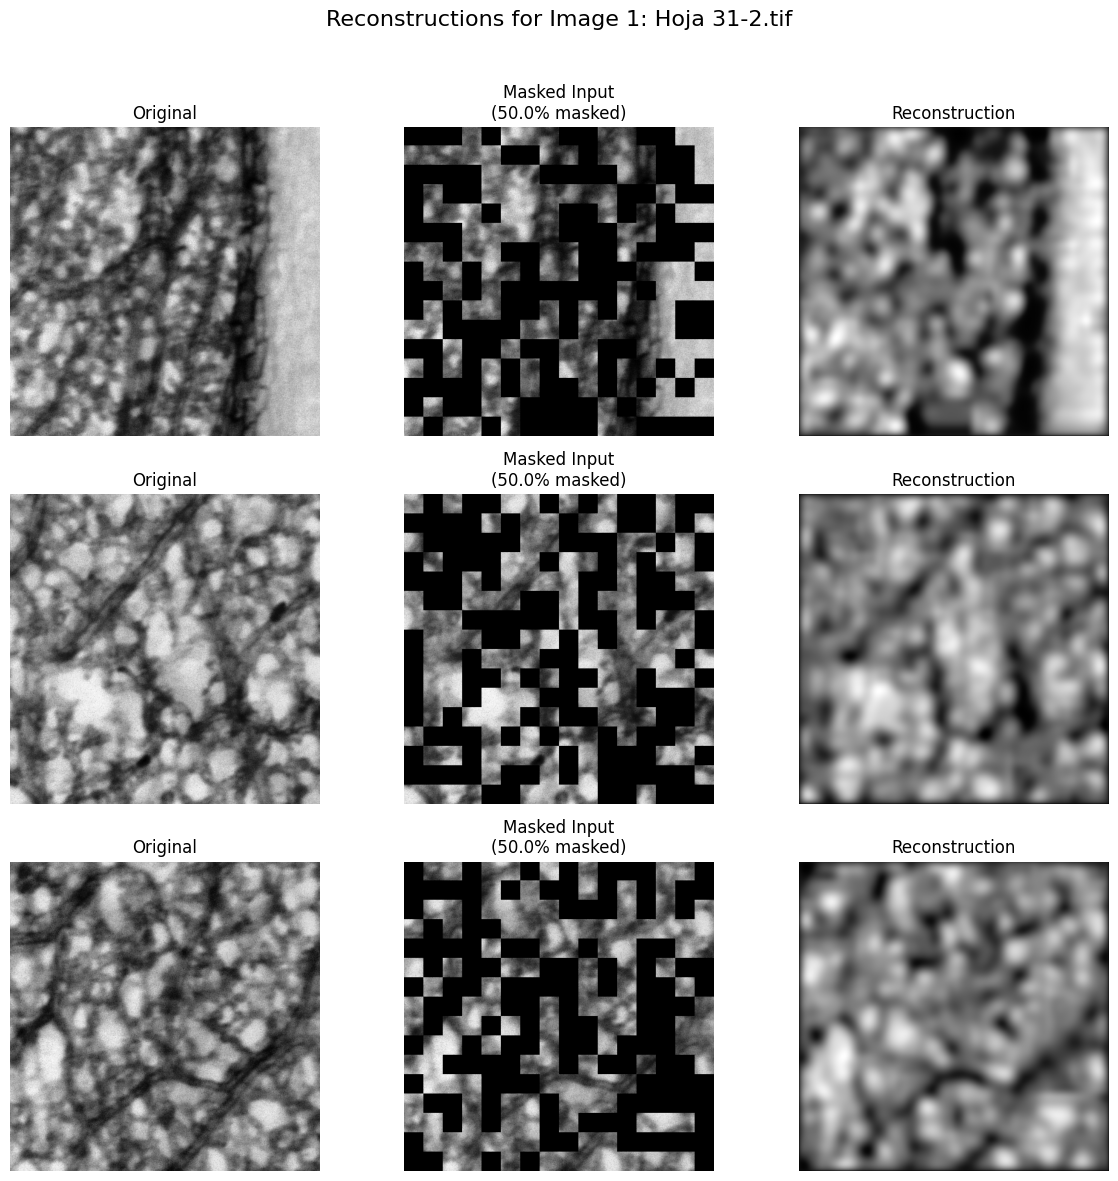

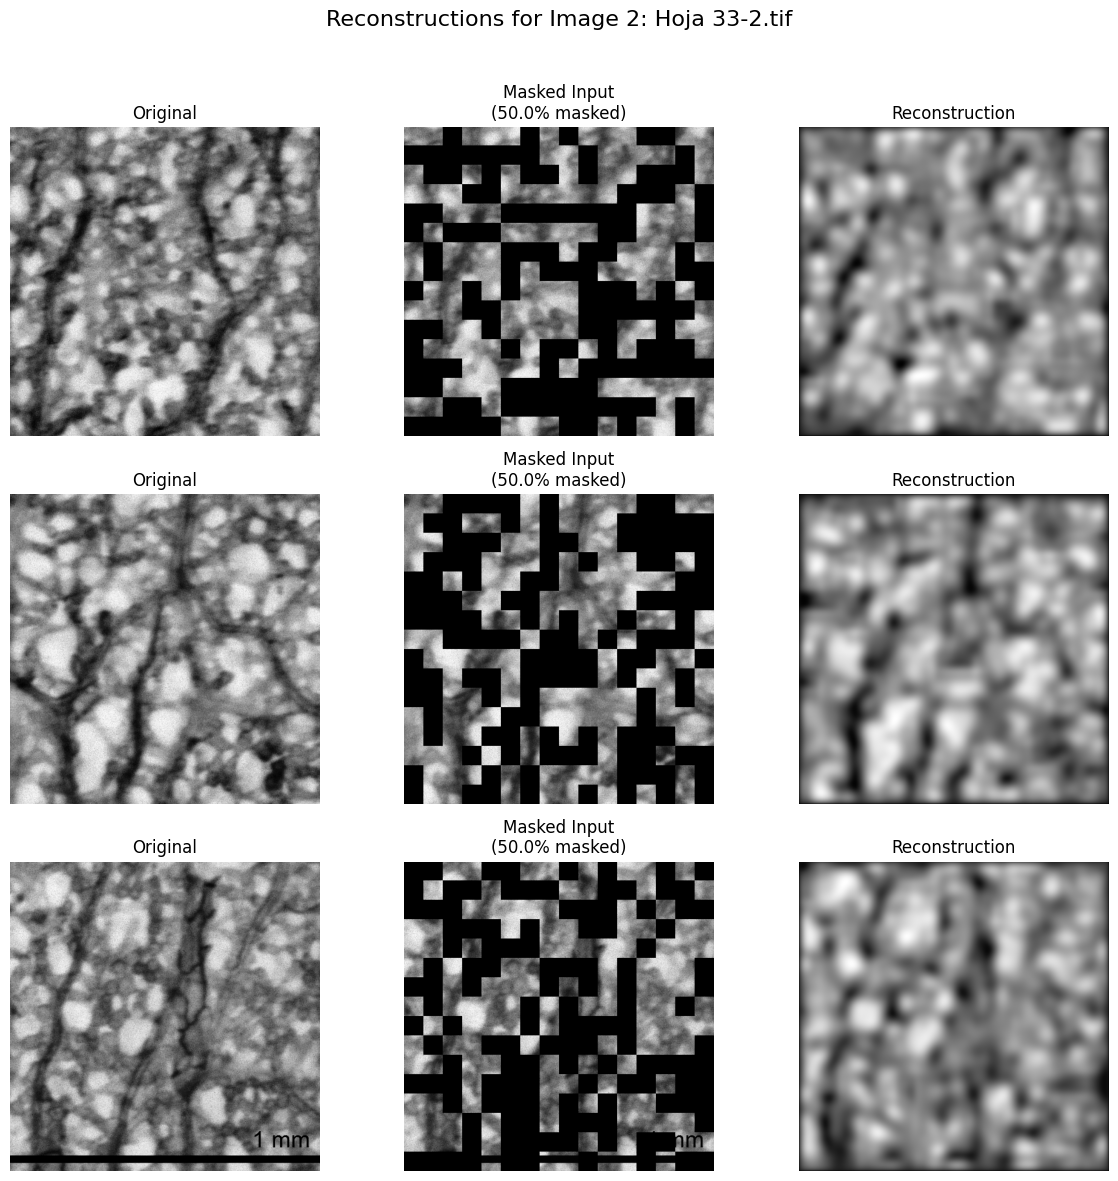

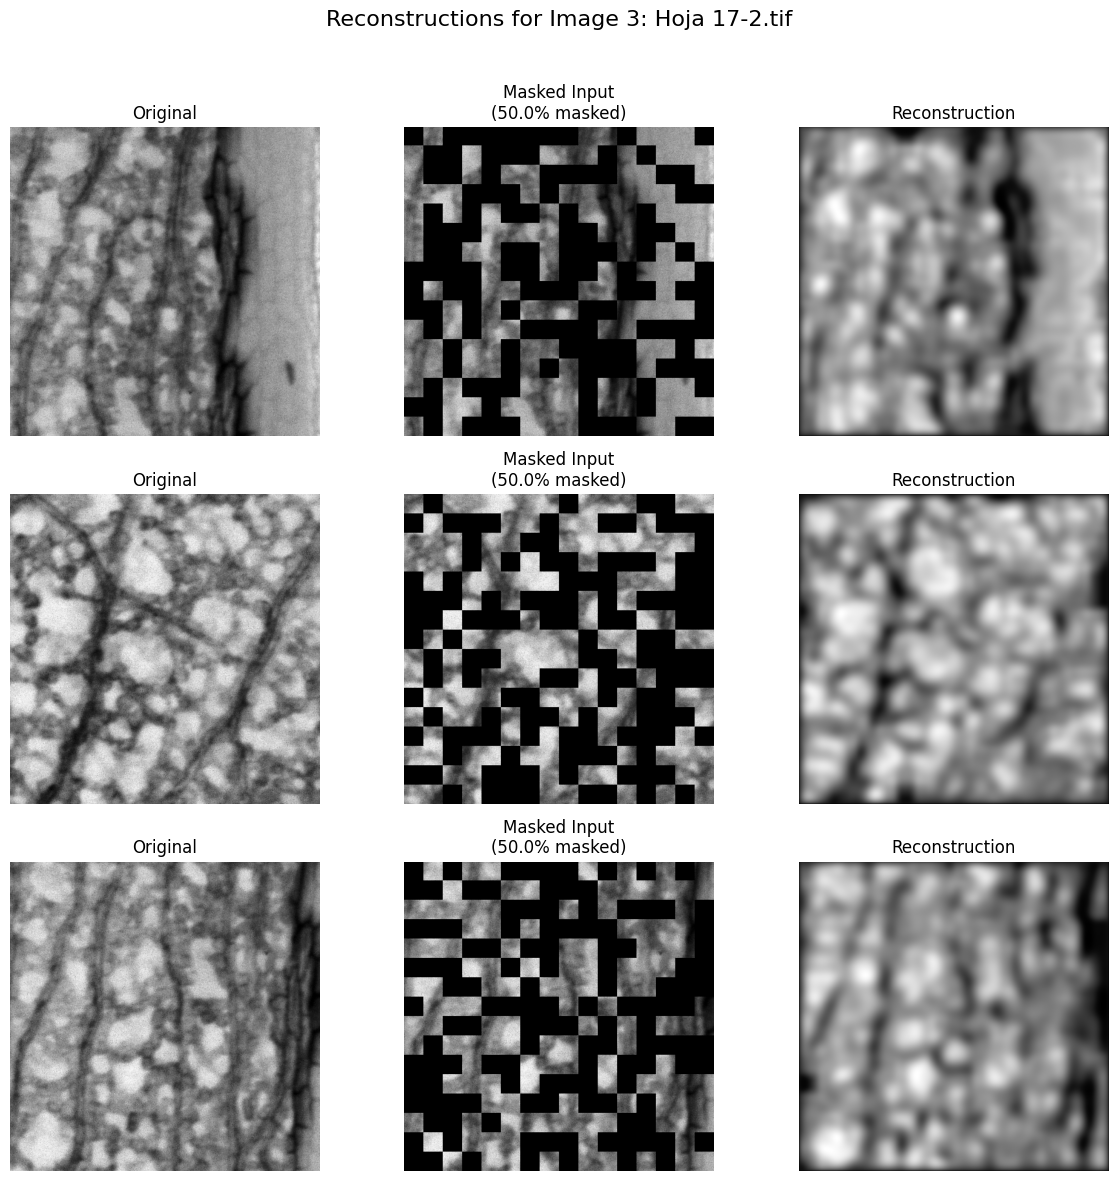

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import random

from masked_autoencoder import MaskedAutoencoder


def random_crops(img, crop_size=512, num_crops=3):
    """Return a list of random cropped patches (PIL Images) of size crop_size."""
    w, h = img.size
    crops = []
    if w < crop_size or h < crop_size:
        raise ValueError(f"Image too small for crop size {crop_size}: {w}x{h}")

    for _ in range(num_crops):
        left = random.randint(0, w - crop_size)
        top = random.randint(0, h - crop_size)
        crop = img.crop((left, top, left + crop_size, top + crop_size))
        crops.append(crop)
    return crops


def visualize_reconstruction(mae_model, image_paths, device='cuda', num_images=3, crops_per_image=3):
    transform_to_tensor = transforms.ToTensor()

    mae_model.eval()
    mae_model.to(device)

    for i, path in enumerate(image_paths[:num_images]):
        img = Image.open(path).convert("L")

        try:
            patches = random_crops(img, crop_size=512, num_crops=crops_per_image)
        except ValueError as e:
            print(f"Skipping {path}: {e}")
            continue

        fig, axes = plt.subplots(crops_per_image, 3, figsize=(12, 4 * crops_per_image))
        if crops_per_image == 1:
            axes = [axes]  # Make iterable for single row

        for idx, patch in enumerate(patches):
            tensor_patch = transform_to_tensor(patch).unsqueeze(0).to(device)  # [1,1,512,512]

            with torch.no_grad():
                loss, recon, mask = mae_model(tensor_patch)

            orig = tensor_patch.cpu().squeeze().numpy()
            masked = (tensor_patch * mask.float()).cpu().squeeze().numpy()
            recon_np = recon.cpu().squeeze().numpy()

            for ax, image, title in zip(axes[idx], [orig, masked, recon_np], ["Original", "Masked Input", "Reconstruction"]):
                ax.imshow(image, cmap='gray')
                ax.set_title(title)
                ax.axis("off")

        plt.suptitle(f"Reconstructions for Image {i+1}: {os.path.basename(path)}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    root_dir = "/home/smadper/TFM/datasets/laticifers/enhanced_images"
    image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
                   if fname.lower().endswith(('.png', '.jpg', '.tif'))]

    mae = MaskedAutoencoder(mask_ratio=0.5)
    mae.load_state_dict(torch.load("/home/smadper/TFM/mae_full_best3.pth", map_location=device), strict=False)

    visualize_reconstruction(mae, image_paths, device=device, num_images=3, crops_per_image=3)
